# Quantum Simulation of Hamiltonians using Product Formulas

Please execute the cell below before proceeding:

In [189]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit import *
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity, Statevector, Operator, Pauli, SparsePauliOp
from qiskit import Aer
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal, PauliEvolutionGate
from qiskit.algorithms import TimeEvolutionProblem, RealTimeEvolver, RealEvolver, SciPyRealEvolver, VarQRTE
from qiskit.algorithms.time_evolvers import TrotterQRTE
from qiskit.circuit import Parameter, ParameterVector
from qiskit.synthesis import SuzukiTrotter


## Second-quantized Electronic Structure:

### Dihydrogen Molecule (Molecular Orbital Basis):

#### Via Trotterization Method:

In [190]:
# Prepare a Dihydrogen Molecule within its second_q_op structure:

h2_driver = PySCFDriver(
    atom = "H 0 0 0; H 0 0 0.735",
    basis = "sto3g",
    charge = 0,
    spin = 0,
    unit = DistanceUnit.ANGSTROM,
)

# Create Problem instance for dihydrogen molecule:

diHydro_prob = h2_driver.run()

# Generate the Electronic Hamiltonian for Dihydrogen:

h2_Hamiltonian = diHydro_prob.hamiltonian
coefficients = h2_Hamiltonian.electronic_integrals

# Apply second-quantization transformation to Electronic Hamiltonian:

sq_h2_op = h2_Hamiltonian.second_q_op() # This Second-Quantized Electronic Hamiltonian does NOT contain the nuclei repulsive/attractive terms!

# Set up Jordan-Wigner Mapper/Transformer to bring Second Quantized Hamiltonian into qubit space:

jw_map = JordanWignerMapper()

# Apply mapper to Second Quantized Electronic Hamiltonian:

qubit_h2_Ham = jw_map.map(sq_h2_op)

# Obtain the initial state from which to apply the time evolution of the converted Hamiltonian:

HartreeFock_initial = HartreeFock(diHydro_prob.num_spatial_orbitals, diHydro_prob.num_particles, jw_map,)

# Draw the initial state to evolve:

HartreeFock_initial.draw('mpl')

evo_time = Parameter('t')



In [191]:
# Select an appropriate order, accuracy, evolution time, time step size, and Trotter number for the Product Formula:

PF_order = 2 # Order of Product Formula.
final_time = 1 # Termination time of real time evolution.
Trotter_Num = 1 # Trotter number associated with Product Formula construction.
time_step = 0.01 # Time step increment for sampling purposes. Does not affect the Product Formula construction.
epsilon = 1.6 * 10**-3 # Select a desired chemical accuracy for simulation purposes.
evo_time_param = Parameter('time')

evo_time_range = np.arange(0, final_time, time_step) # Define a time evolution range that will scale to the plotted Hamiltonian evolution.


In [192]:
# Define a first order Product Formula generation function:

def First_Order(hamiltonian, initial_state, trot_num, time, step): 

    # Partition each qubit_h2_Ham list object into separate list of exponentiated summands:

    exp_summand = list()
    evo_time = Parameter('t')

    for i in range(0, len(hamiltonian)):
        exp_summand.append(PauliEvolutionGate(hamiltonian[i], time=evo_time))

    # Append PauliEvolutionGates to template circuit, emulating a first order trotterization scheme:

    PF_circuit = QuantumCircuit(initial_state.width())

    for i in range(len(exp_summand)):
        PF_circuit.append(exp_summand[i], range(initial_state.width()))

    composed_circ = initial_state

    for i in range(trot_num):
        composed_circ = composed_circ.compose(PF_circuit, range(initial_state.width()))

    return (composed_circ) # Return the composed first order Product Formula circuit.
    

In [195]:
# Define general Product Formula creation function:

def product_formula(hamiltonian, initial_state, order, trot_num, time, time_step):

    # hamiltonian = PauliOp or SparsePauliOp Hamiltonian to be Trotterized.
    # initial_state = Initial QuantumCircuit configuration from which the system will be evolved. 
    # order = Order of the desired Product Formula.
    # trot_num = Desired Trotter Number for the Product Formula.
    # time = Time to which the Product Formula will evolve.
    # time_step = Increments at which the system will evolve. 

    if (order < 1):
        return ("Invalid Order Chosen. Choose an integer from [1, inf].") 
    elif (order == 1):
        return First_Order(hamiltonian, initial_state, trot_num, time, time_step)
    elif (order >= 2):
        gate = PauliEvolutionGate(qubit_h2_Ham, time=evo_time_param)
        Suzuki = SuzukiTrotter(order, trot_num, insert_barriers=True).synthesize(gate)
        return HartreeFock_initial.compose(Suzuki)
    else:
        return ("Invalid Order Chosen. Use integers!")
        

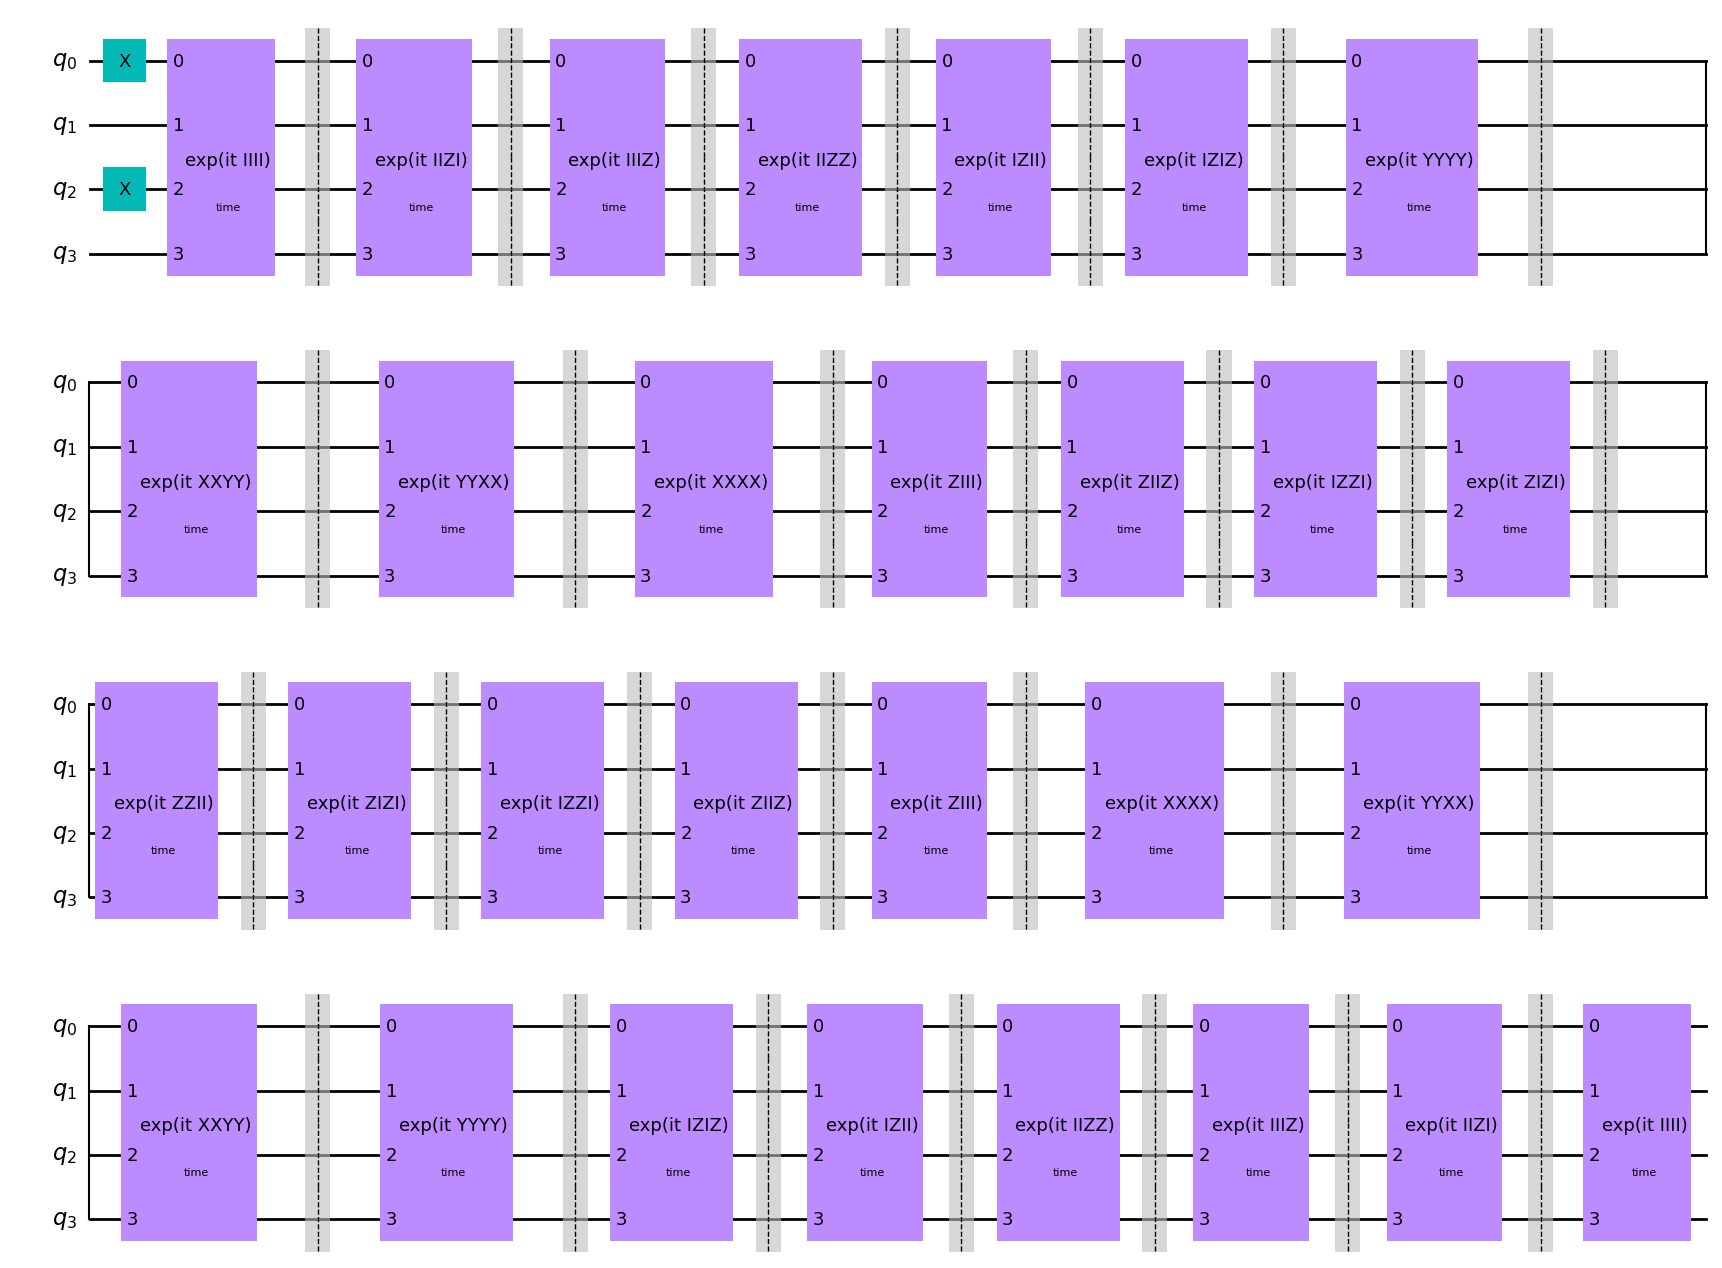

In [196]:
# Obtain the desired Product Formula circuit and draw it:
'''Warning: Circuits grow exponentially in gate complexity (i.e, size) relative to order! Be careful when drawing higher-order circuits!'''

PF_circ = product_formula(qubit_h2_Ham, HartreeFock_initial, PF_order, Trotter_Num, final_time, time_step)

PF_circ.draw('mpl')

In [201]:
# Prepare an estimator to measure expectation value of Hamiltonian:

h2_energies = list()
estimator = Estimator()

if (PF_order == 1):

    for k in range(len(evo_time_range)):
        result = estimator.run(PF_circ, qubit_h2_Ham, parameter_values=(evo_time_range[k]/Trotter_Num)).result()
        h2_energies.append(np.real(result.values))

else: 

    for k in range(len(evo_time_range)):
        
        result = estimator.run(PF_circ, qubit_h2_Ham, parameter_values= 1).result()
        h2_energies.append(np.real(result.values))

# Graph the energy variation over the specified time interval:

plt.plot(evo_time_range, h2_energies, color="royalblue")
plt.xlabel("Time (s)")
plt.ylabel("Energy (Hartree)")
plt.title("Expectation Value of Dihydrogen w/ Trotter Number = " + str(Trotter_Num))

TypeError: ParameterExpression with unbound parameters ({Parameter(time)}) cannot be cast to a float.

In [46]:
# Calculate the expected Trotter Error for Electronic structure Hamiltonian:

alpha_comm = (qubit_h2_Ham.num_qubits)**(PF_order + 1)

h2_error = alpha_comm * evo_time_range[-1]**(PF_order + 1)

print("The expected error term of the Lie-Trotter-style algorithm is: O(" + str(h2_error) + ")")


The expected error term of the Lie-Trotter-style algorithm is: O(62.099136)


20R, 100s: O(112275.11250000002)

In [138]:
# Calculate necessary Trotter_Num to achieve chemical accuracy constant:

trotter_num_need = (((qubit_h2_Ham.num_qubits * evo_time_range[-1])**(1+1/PF_order)) / epsilon**(1/PF_order))
print(trotter_num_need)

####### PLOT ORDER NUMBER VS TROTER NUM NEED TO ACHIEVE ACCURACY 

224700100.0


#### Via Standard Tools:

In [75]:
#from qiskit_nature.second_q.circuit.library import BogoliubovTransform
#from qiskit.
standard_evo_time_range_h2 = np.arange(0, 10000, 1)

(array([-1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, 

Text(0.5, 1.0, 'Energy over time')

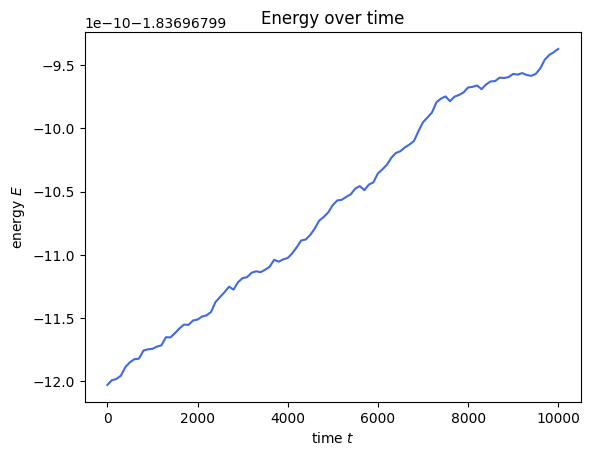

In [76]:
# Invoke the TimeEvolutionProblem to create a problem instance for an evolver:

standard_problem = TimeEvolutionProblem(qubit_h2_Ham, time=standard_evo_time_range_h2[-1], initial_state=HartreeFock_initial, aux_operators=[qubit_h2_Ham, Pauli("IIII")]) # Create the TimeEvolutionProblem on the Dihydrogen Qubit Hamiltonian.

# Invoke the SciPyRealEvolver to create a TimeEvolutionResult instance:

SciPy = SciPyRealEvolver(100)

# Evolve the Dihydrogen Hamiltonian with respect to the initial Hartree-Fock State:

standard_result = SciPy.evolve(standard_problem)

print(standard_result.observables[0])

# Graph the resulting real time evolution of the system:

energies = np.real(standard_result.observables)[:, 0]

plt.plot(standard_result.times, energies[0], color="royalblue")
plt.xlabel("time $t$")
plt.ylabel("energy $E$")
plt.title("Energy over time")

Lattice-based Hamiltonians:

In [4]:
from math import pi
from qiskit_nature.second_q.hamiltonians.lattices import(
    BoundaryCondition,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel, HeisenbergModel, IsingModel
from qiskit_nature.second_q.mappers import LinearMapper
from qiskit.circuit.library import EfficientSU2

Heisenberg Model (Lattice-based):

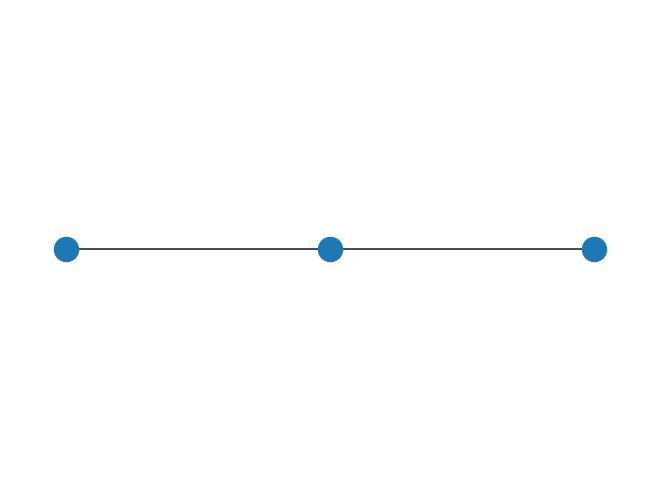

In [17]:
# Instantiate Line_Lattice for Hamiltonian generation:

line_lattice = LineLattice(num_nodes=3, boundary_condition=BoundaryCondition.OPEN)
heisenberg_model = HeisenbergModel(line_lattice, (1.0, 1.0, 1.0), (0.0, 0.0, 1.0))
line_lattice.draw()

In [18]:
# Obtain Second Quantized operator of Heisenberg Model Hamiltonian:

hb_Ham = heisenberg_model.second_q_op()

# Invoke Linear Mapper/Transformation to bring Hamiltonian into Qubit Space:

lin_map = LinearMapper()

qubit_hb_Ham = lin_map.map(hb_Ham)

#print(qubit_hb_Ham)
#print(qubit_hb_Ham.num_qubits)
#print(hb_Ham)

Spin Operator
spin=1/2, number spins=3, number terms=9
  1.0 * ( X_0 X_1 )
+ 1.0 * ( Y_0 Y_1 )
+ 1.0 * ( Z_0 Z_1 )
+ 1.0 * ( X_1 X_2 )
+ 1.0 * ( Y_1 Y_2 )
+ 1.0 * ( Z_1 Z_2 )
+ 1.0 * ( Z_0 )
+ 1.0 * ( Z_1 )
+ 1.0 * ( Z_2 )


In [866]:
# Construct appropriate ansatz for Variational Time Evolution:

hb_initial_state = QuantumCircuit(qubit_hb_Ham.num_qubits)
hb_initial_state.x(range(0, qubit_hb_Ham.num_qubits, 2))

#hb_initial_state.draw('mpl') # Known as the Néel state of a Lattice-based Hamiltonian

In [894]:
# Generate an appropriate first order trotterization scheme for Heisenberg Model:

hb_exp_summand = list()
hb_evo_time_range = np.arange(0, 1, 0.1)
hb_evo_time = Parameter('t')

for i in range(0, len(qubit_hb_Ham)):
    hb_exp_summand.append(PauliEvolutionGate(qubit_hb_Ham[i], time=evo_time))

#print(len(hb_exp_summand))

In [895]:
# Append PauliEvolutionGates to template circuit, emulating a first order trotterization scheme:

hb_PF_circuit = QuantumCircuit(hb_exp_summand[0].num_qubits)

for i in range(len(hb_exp_summand)):
    hb_PF_circuit.append(hb_exp_summand[i], range(hb_exp_summand[i].num_qubits))

#hb_PF_circuit.draw('mpl')

In [896]:
# Append Product Formula to initial state circuit, initiating a first order trotterization scheme:

hb_Trotter_Num = 20 # Num of Trotter_Num for approximation purposes

hb_composed_circ = hb_initial_state

for i in range(hb_Trotter_Num):
    hb_composed_circ = hb_composed_circ.compose(hb_PF_circuit, range(hb_initial_state.width()))

#hb_composed_circ.draw()

In [897]:
# Prepare an estimator to measure expectation value of Hamiltonian:

hb_energies = list()
estimator = Estimator()

for k in range(len(hb_evo_time_range)):
    hb_result = estimator.run(hb_composed_circ, qubit_hb_Ham, parameter_values=(hb_evo_time_range[k]/hb_Trotter_Num)).result()
    hb_energies.append(np.real(hb_result.values))

Text(0.5, 1.0, 'Expectation Value of Heisenberg Hamiltonian over Trotterization Evolution')

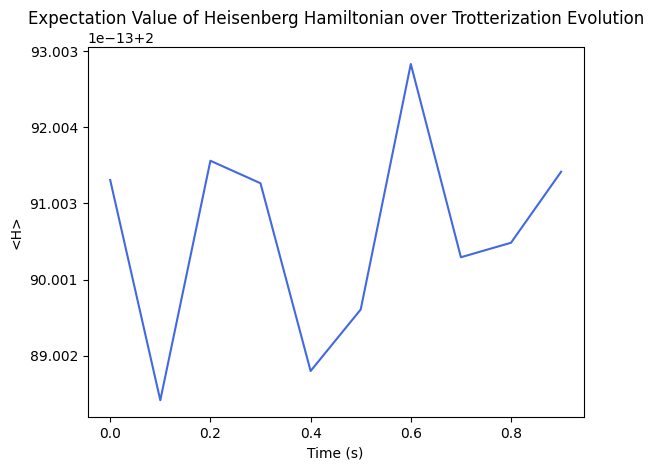

In [898]:
# Graph the energy variation over the specified time interval:

plt.plot(hb_evo_time_range, hb_energies, color="royalblue")
plt.xlabel("Time (s)")
plt.ylabel("<H>")
plt.title("Expectation Value of Heisenberg Hamiltonian over Trotterization Evolution")

In [821]:
# Calculate the expected and actual error:

hb_error = (len(hb_exp_summand)**2 * hb_evo_time_range[-1]**2) / hb_Trotter_Num

print("The expected error term of the Lie-Trotter-style algorithm is: O(" + str(hb_error) + ")")

The expected error term of the Lie-Trotter-style algorithm is: O(117612.0)


Ising Model (Lattice-based):

In [801]:
# Instantiate Line_Lattice for Hamiltonian generation:

line_lattice = LineLattice(num_nodes=3, boundary_condition=BoundaryCondition.OPEN)
ising_model = IsingModel(
    line_lattice.uniform_parameters(
        uniform_interaction = -1.0,
        uniform_onsite_potential = 0.0,
    ),
)

In [802]:
# Obtain Second Quantized operator of Ising Model Hamiltonian:

i_Ham = ising_model.second_q_op()

# Invoke Linear Mapper/Transformation to bring Hamiltonian into Qubit Space:

lin_map = LinearMapper()

qubit_i_Ham = lin_map.map(i_Ham)

print(qubit_i_Ham)
#print(qubit_hb_Ham.num_qubits)

-0.0625 * IIZIZI
- 0.0625 * IIZIII
+ 0.0625 * IIZIIZ
+ 0.0625 * IIZIII
- 0.0625 * IIIIZI
- 0.0625 * IIIIII
+ 0.0625 * IIIIIZ
+ 0.0625 * IIIIII
+ 0.0625 * IIIZZI
+ 0.0625 * IIIZII
- 0.0625 * IIIZIZ
- 0.0625 * IIIZII
+ 0.0625 * IIIIZI
+ 0.0625 * IIIIII
- 0.0625 * IIIIIZ
- 0.0625 * IIIIII
- 0.0625 * ZIZIII
- 0.0625 * ZIIIII
+ 0.0625 * ZIIZII
+ 0.0625 * ZIIIII
- 0.0625 * IIZIII
- 0.0625 * IIIIII
+ 0.0625 * IIIZII
+ 0.0625 * IIIIII
+ 0.0625 * IZZIII
+ 0.0625 * IZIIII
- 0.0625 * IZIZII
- 0.0625 * IZIIII
+ 0.0625 * IIZIII
+ 0.0625 * IIIIII
- 0.0625 * IIIZII
- 0.0625 * IIIIII


In [803]:
# Construct appropriate ansatz for Real Time Evolution:

i_initial_state = QuantumCircuit(qubit_i_Ham.num_qubits)
i_initial_state.x(range(0, qubit_i_Ham.num_qubits, 2))

#hb_initial_state.draw('mpl') # Known as the Néel state of a Lattice-based Hamiltonian

In [909]:
# Generate an appropriate first order trotterization scheme for Ising Model:

i_exp_summand = list()
i_evo_time_range = np.arange(0, 5, 0.01)
i_evo_time = Parameter('t')

for i in range(0, len(qubit_i_Ham)):
    i_exp_summand.append(PauliEvolutionGate(qubit_i_Ham[i], time=i_evo_time))

In [910]:
# Append PauliEvolutionGates to template circuit, emulating a first order trotterization scheme:

i_PF_circuit = QuantumCircuit(i_exp_summand[0].num_qubits)

for i in range(len(i_exp_summand)):
    i_PF_circuit.append(i_exp_summand[i], range(i_exp_summand[i].num_qubits))

#hb_PF_circuit.draw('mpl')

In [911]:
# Append Product Formula to initial state circuit, initiating a first order trotterization scheme:

i_Trotter_Num = 100 # Num of Trotter_Num for approximation purposes

i_composed_circ = i_initial_state

for i in range(i_Trotter_Num):
    i_composed_circ = i_composed_circ.compose(i_PF_circuit, range(i_initial_state.width()))

#hb_composed_circ.draw('mpl')

In [912]:
# Prepare an estimator to measure expectation value of Hamiltonian:

i_energies = list()
estimator = Estimator()

for k in range(len(i_evo_time_range)):
    i_result = estimator.run(i_composed_circ, qubit_i_Ham, parameter_values=(i_evo_time_range[k]/i_Trotter_Num)).result()
    i_energies.append(np.real(i_result.values))

Text(0.5, 1.0, 'Expectation Value of Ising Hamiltonian over Trotterization Evolution')

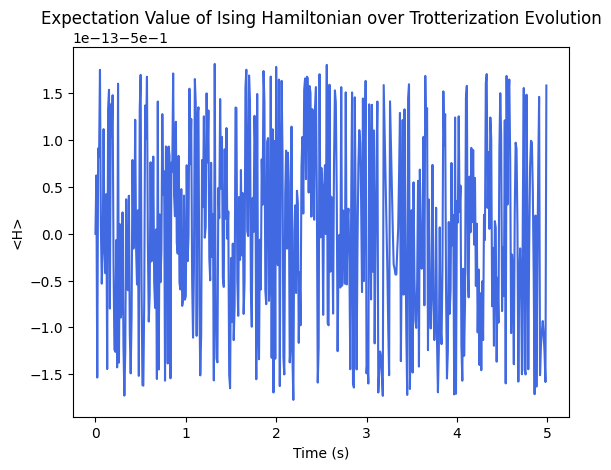

In [918]:
# Graph the energy variation over the specified time interval:

plt.plot(i_evo_time_range, i_energies, color="royalblue")
plt.xlabel("Time (s)")
#plt.xlim(0, 1)
plt.ylabel("<H>")
plt.title("Expectation Value of Ising Hamiltonian over Trotterization Evolution")

In [920]:
# Calculate the expected and actual error:

i_error = (len(i_exp_summand)**2 * i_evo_time_range[-1]**2) / i_Trotter_Num

print("The expected error term of the Lie-Trotter-style algorithm is: O(" + str(i_error) + ")")

The expected error term of the Lie-Trotter-style algorithm is: O(254.97702400000003)
